In [1]:
# Importing the libraries
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import numpy as np

In [2]:
torch.__version__

'2.1.1+cu118'

In [3]:
# Setting some hyperparameters
batchSize = 64 # the size of the batch.
imageSize = 64 # the size of the generated images (64x64).

# Creating the transformations (scaling, tensor conversion, normalization) to apply to the input images.
transform = transforms.Compose([transforms.Resize(imageSize), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),]) 

# Loading the dataset
dataset = dset.CIFAR10(root = './data', download = True, transform = transform) 
dataloader = torch.utils.data.DataLoader(dataset, batch_size = batchSize, shuffle = True, num_workers = 2) 

# Defining the weights_init function that takes as input a neural network m and that will initialize all its weights.
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

Files already downloaded and verified


In [4]:
# Defining the generator

class G(nn.Module): 

    def __init__(self): 
        super(G, self).__init__() 
        self.main = nn.Sequential( # a meta module of a neural network that will contain a sequence of modules (convolutions, full connections, etc.).
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias = False), # start with an inversed convolution.
            nn.BatchNorm2d(512), # normalize all the features along the dimension of the batch.
            nn.ReLU(True), # apply a ReLU rectification to break the linearity.
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias = False), #  add another inversed convolution.
            nn.BatchNorm2d(256), #normalize again.
            nn.ReLU(True), # apply another ReLU.
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias = False), 
            nn.BatchNorm2d(128), 
            nn.ReLU(True), 
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias = False), 
            nn.BatchNorm2d(64), 
            nn.ReLU(True), 
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias = False), 
            nn.Tanh() # We apply a Tanh rectification to break the linearity and stay between -1 and +1.
        )

    def forward(self, input): # We define the forward function that takes as argument an input that will be fed to the neural network, and that will return the output containing the generated images.
        output = self.main(input) 
        return output 

# Creating the generator
netG = G() 
netG.apply(weights_init) # initialize all the weights of its neural network.


G(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [5]:
# Defining the discriminator

class D(nn.Module): 

    def __init__(self): 
        super(D, self).__init__() 
        self.main = nn.Sequential( # a meta module of a neural network that will contain a sequence of modules (convolutions, full connections, etc.).
            nn.Conv2d(3, 64, 4, 2, 1, bias = False), 
            nn.LeakyReLU(0.2, inplace = True), 
            nn.Conv2d(64, 128, 4, 2, 1, bias = False), 
            nn.BatchNorm2d(128), 
            nn.LeakyReLU(0.2, inplace = True), 
            nn.Conv2d(128, 256, 4, 2, 1, bias = False), 
            nn.BatchNorm2d(256), 
            nn.LeakyReLU(0.2, inplace = True), 
            nn.Conv2d(256, 512, 4, 2, 1, bias = False), 
            nn.BatchNorm2d(512), 
            nn.LeakyReLU(0.2, inplace = True), 
            nn.Conv2d(512, 1, 4, 1, 0, bias = False), 
            nn.Sigmoid() # We apply a Sigmoid rectification to break the linearity and stay between 0 and 1.
        )

    def forward(self, input): 
        output = self.main(input) 
        return output.view(-1) # return the output which will be a value between 0 and 1.

# Creating the discriminator
netD = D() 
netD.apply(weights_init)

D(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [6]:
# Training the DCGANs
import time
criterion = nn.BCELoss() # a criterion object that will measure the error between the prediction and the target.
optimizerD = optim.Adam(netD.parameters(), lr = 0.0002, betas = (0.5, 0.999)) 
optimizerG = optim.Adam(netG.parameters(), lr = 0.0002, betas = (0.5, 0.999)) 
generator_error = []
discriminator_error = []
try:
    for epoch in range(30):

        start = time.time()
        gen_error =[]
        disc_error = []
        for i, data in enumerate(dataloader, 0): # We iterate over the images of the dataset.

            # 1st Step: Updating the weights of the neural network of the discriminator

            netD.zero_grad() # initialize to 0 the gradients of the discriminator with respect to the weights.
            
            # Training the discriminator with a real image of the dataset
            real, _ = data # get a real image of the dataset which will be used to train the discriminator.
            input = Variable(real) # wrap it in a variable.
            target = Variable(torch.ones(input.size()[0])) # get the target.
            output = netD(input) #forward propagate this real image into the neural network of the discriminator to get the prediction (a value between 0 and 1).
            errD_real = criterion(output, target) #compute the loss between the predictions (output) and the target (equal to 1).
            
            # Training the discriminator with a fake image generated by the generator
            noise = Variable(torch.randn(input.size()[0], 100, 1, 1)) # make a random input vector (noise) of the generator.
            fake = netG(noise) # forward propagate this random input vector into the neural network of the generator to get some fake generated images.
            target = Variable(torch.zeros(input.size()[0])) #get the target.
            output = netD(fake.detach()) #forward propagate the fake generated images into the neural network of the discriminator to get the prediction (a value between 0 and 1).
            errD_fake = criterion(output, target) # compute the loss between the prediction (output) and the target (equal to 0).

            # Backpropagating the total error
            errD = errD_real + errD_fake 
            errD.backward() 
            optimizerD.step() 

            # 2nd Step: Updating the weights of the neural network of the generator

            netG.zero_grad() #initialize to 0 the gradients of the generator with respect to the weights.
            target = Variable(torch.ones(input.size()[0])) # get the target.
            output = netD(fake) #forward propagate the fake generated images into the neural network of the discriminator to get the prediction (a value between 0 and 1).
            errG = criterion(output, target) #compute the loss between the prediction (output between 0 and 1) and the target (equal to 1).
            errG.backward() #backpropagate the loss error by computing the gradients of the total error with respect to the weights of the generator.
            optimizerG.step() # apply the optimizer to update the weights according to how much they are responsible for the loss error of the generator.

            
            # Loss Calculation
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f' % (epoch+1, 30, i, len(dataloader), errD.data, errG.data)) # We print les losses of the discriminator (Loss_D) and the generator (Loss_G).
            gen_error.append(errG.data)
            disc_error.append(errD.data)
            if i % 100 == 0: # Every 100 steps:
                vutils.save_image(real, '%s/real_samples_epoch_%03d.png' % ("./results", epoch+1), normalize = True) # We save the real images of the minibatch.
                fake = netG(noise) # We get our fake generated images.
                vutils.save_image(fake.data, '%s/fake_samples_epoch_%03d.png' % ("./results", epoch+1), normalize = True) # We also save the fake generated images of the minibatch.
        end = time.time()
        generator_error.append(np.array(gen_error).mean())
        discriminator_error.append(np.array(disc_error).mean())
        print(f'*****Epoch : [{epoch+1}/30]*****\nTime Elapsed: {end-start:.3f}secs, Loss_G: {np.array(gen_error).mean():.4f}, Loss_D: {np.array(disc_error).mean():.4f}\n')
except KeyboardInterrupt:
    print('Stopping')

[1/30][0/782] Loss_D: 1.9679 Loss_G: 6.6464
[1/30][1/782] Loss_D: 1.2183 Loss_G: 5.1587
[1/30][2/782] Loss_D: 1.1117 Loss_G: 6.0151
[1/30][3/782] Loss_D: 0.9702 Loss_G: 6.7776
[1/30][4/782] Loss_D: 0.6856 Loss_G: 6.6800
[1/30][5/782] Loss_D: 0.8743 Loss_G: 7.4451
[1/30][6/782] Loss_D: 0.7572 Loss_G: 7.6873
[1/30][7/782] Loss_D: 0.7539 Loss_G: 7.8654
[1/30][8/782] Loss_D: 0.7573 Loss_G: 8.5514
[1/30][9/782] Loss_D: 0.5970 Loss_G: 9.1494
[1/30][10/782] Loss_D: 0.6587 Loss_G: 7.8679
[1/30][11/782] Loss_D: 0.8958 Loss_G: 12.1151
[1/30][12/782] Loss_D: 0.3606 Loss_G: 9.2138
[1/30][13/782] Loss_D: 0.6692 Loss_G: 10.9694
[1/30][14/782] Loss_D: 0.5755 Loss_G: 8.8968
[1/30][15/782] Loss_D: 0.8539 Loss_G: 13.0543
[1/30][16/782] Loss_D: 0.4462 Loss_G: 9.3265
[1/30][17/782] Loss_D: 0.9992 Loss_G: 13.9686
[1/30][18/782] Loss_D: 0.2242 Loss_G: 10.7037
[1/30][19/782] Loss_D: 0.6529 Loss_G: 12.4514
[1/30][20/782] Loss_D: 0.4148 Loss_G: 10.3888
[1/30][21/782] Loss_D: 0.6680 Loss_G: 14.8616
[1/30][22/78

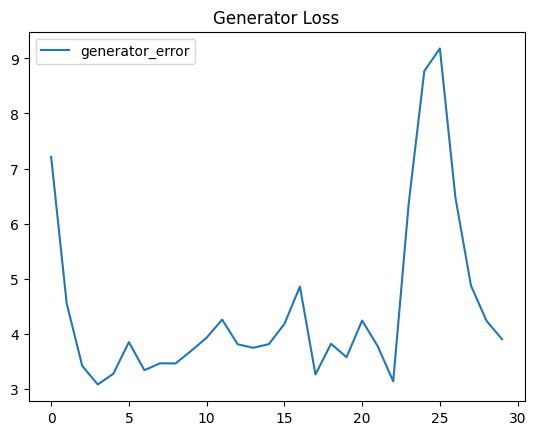

In [12]:
import matplotlib.pyplot as plt

plt.plot(np.arange(len(generator_error)),np.array(generator_error),label='generator_error')

plt.title('Generator Loss')
plt.legend();

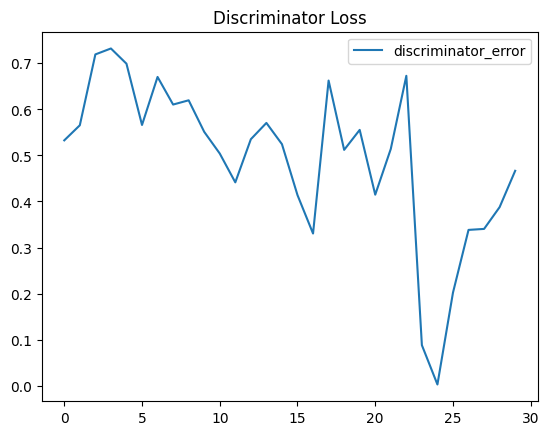

In [13]:
plt.plot(np.arange(len(generator_error)),discriminator_error,label='discriminator_error')
plt.title('Discriminator Loss')
plt.legend();

In [45]:
noise = Variable(torch.randn(input.size()[0], 100, 1, 1))
fake = netG(noise) # We get our fake generated images.
vutils.save_image(fake.data, '%s/test.png' % ("./results"), normalize = True)